<a href="https://colab.research.google.com/github/onuralpArsln/IoUScoreMaker/blob/main/colab/pc12model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0

---



Imports and function to show output images

use !wget block to load images and model in your runtime

In [ ]:
# imports for project
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow

In [ ]:
# get files into your run time
!wget https://github.com/onuralpArsln/IoUScoreMaker/blob/main/colab/002.jpg
!wget https://github.com/onuralpArsln/IoUScoreMaker/blob/main/colab/best_model.hdf5
!wget https://github.com/onuralpArsln/IoUScoreMaker/blob/main/colab/mask_002.png

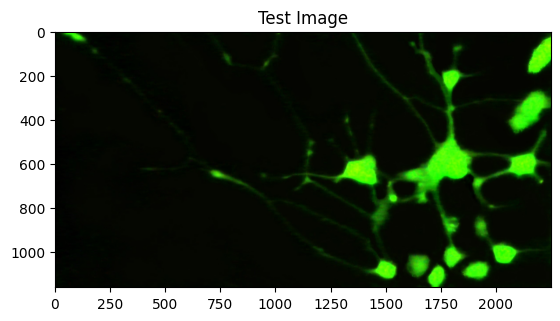

In [ ]:
###this is to test current system

def test_show(image,imname="Test Image"):

    plt.imshow(image)
    plt.title(imname)
    plt.show()

image=cv2.imread("002.jpg")
test_show(image)

# Step 1

---

Makes prediction with model on regular input
Makes another prediction with preprocessed image to  detect branches

In [ ]:
# Step 2 guess for better image prediction system

# this image process make brightnes 3.4 and contrast 0.4 to improve readibility of image

def imgProces( img : np.ndarray) -> np.ndarray:
    alpha = 0.4  # Contrast control (1.0 means no change)
    beta = 2.4    # Brightness control (0 means no change)
    adjusted_image = cv2.convertScaleAbs(input_image, alpha=alpha, beta=beta)
    return adjusted_image


input_image_path = '002.jpg'
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
input_image = cv2.resize(input_image, (256, 256))  # Giriş boyutunu (256, 256) olarak yeniden boyutlandırma
input_image = np.expand_dims(input_image, axis=-1)  # Tek bir kanal ekleyerek (256, 256) boyutunu (256, 256, 1) olarak genişletiyoruz

result = imgProces(input_image)

result_path = '002res.jpg'




proces_path = '002.jpg'
proces_image = cv2.imread(proces_path, cv2.IMREAD_GRAYSCALE)
proces_image = cv2.resize( proces_image, (256, 256))  # Giriş boyutunu (256, 256) olarak yeniden boyutlandırma
proces_image = np.expand_dims( proces_image, axis=-1)  # Tek bir kanal ekleyerek (256, 256) boyutunu (256, 256,




threshold_value = 20

# Binarize the image using the threshold

def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-5) / (union + 1e-5)

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-5) / (union + 1e-5)
# Modeli yükleme sırasında özel metrik fonksiyonları tanımlama
with tf.keras.utils.custom_object_scope({'dice_coef': dice_coef, 'iou_score': iou_score}):
    model_path = 'best_model.hdf5'
    model = tf.keras.models.load_model(model_path)

prediction_result = model.predict(np.expand_dims(input_image, axis=0))
prediction_result = (prediction_result * 255).astype(np.uint8)

prediction_result2 = model.predict(np.expand_dims(proces_image, axis=0))
prediction_result2 = (prediction_result * 255).astype(np.uint8)




Original Image


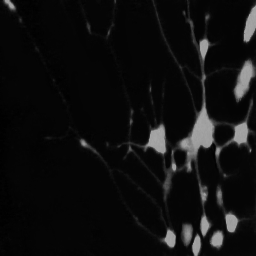



Processed Image


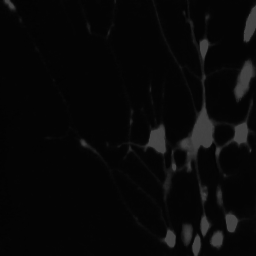



Guessed Image


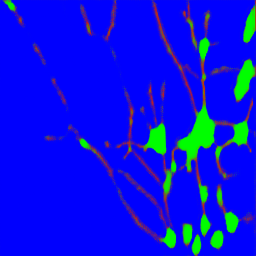



Guessed  Processed Image


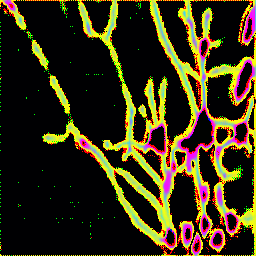

True

In [ ]:
# display reults of step 2

# Display the original and binary images
# instead cv2.imshow from google.colab.patches import cv2_imshow is used since it is for google colab
print('Original Image')
cv2_imshow(input_image)
print("")
print("")
print('Processed Image')
cv2_imshow( result)
print("")
print("")
print('Guessed Image')
cv2_imshow( prediction_result[0])
print("")
print("")
print('Guessed  Processed Image')
cv2_imshow( prediction_result2[0])



#  result processe predict and regular predict
cv2.imwrite("res_pp.png",  prediction_result2[0])
cv2.imwrite("res_rp.png",  prediction_result[0])



# Step 2

---

Pre Processed image have some noise on it we will clear it on this step


In [ ]:
# Reading image from folder where it is stored
img = cv2.imread('res_pp.png')


# denoising of image saving it into dst image
dst = cv2.fastNlMeansDenoisingColored(img, None, 30, 10, 7, 5)

"""
First parameter: This is the input image that you want to denoise. It should be a colored image in
 BGR format (OpenCV's default color format).

second parameter: This parameter is the output denoised image. Since it's set to None, the function will return the
 denoised image as the result.

third parameter : This is the strength of the denoising. A higher value means stronger denoising.

fourth parameter: This parameter controls the filter strength for luminance component.
It's similar to the previous parameter but specifically for the luminance component (brightness).


fifth parameter: This is the size of the window for the noise estimation.
A larger value means that more pixels will be considered when estimating the noise.

sixsth parameter : This is the size of the window for filtering. A larger value means that more pixels will
be considered when filtering, which can result in smoother output but might lose some details.
"""

gdg = cv2.GaussianBlur(dst,(3,3),0)


cv2.imwrite("res_gdg.png", gdg)


True

Cleared Processed  Image


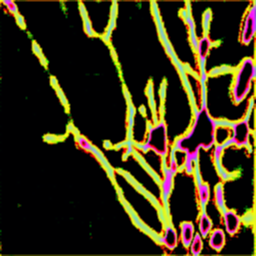

In [ ]:
print('Cleared Processed  Image')
cv2_imshow(gdg)

# Step 3

---

Using regular predicton we can find cell bodies and measure size

Binarized predict


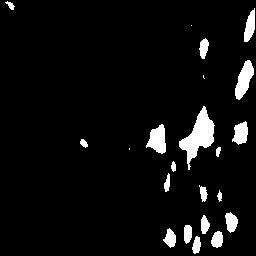

In [ ]:
##to detect bodies

def binarize_image(image_path, threshold_value):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply binary thresholding
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    return binary_image

threshold_value = 127  # Adjust this threshold value as needed

image_path = 'res_rp.png'


binary_rp = binarize_image(image_path, threshold_value)
cv2.imwrite('binarizedDefaultGuess.jpg', binary_rp)
print('Binarized predict')
cv2_imshow(binary_rp)

Cell Body 1: Position (Centroid) = (10.09, 4.98), Size (Area) = 43
Cell Body 2: Position (Centroid) = (249.49, 26.07), Size (Area) = 239
Cell Body 3: Position (Centroid) = (191.00, 25.00), Size (Area) = 1
Cell Body 4: Position (Centroid) = (203.42, 47.65), Size (Area) = 139
Cell Body 5: Position (Centroid) = (243.79, 79.29), Size (Area) = 424
Cell Body 6: Position (Centroid) = (203.25, 76.50), Size (Area) = 4
Cell Body 7: Position (Centroid) = (198.28, 135.65), Size (Area) = 943
Cell Body 8: Position (Centroid) = (240.41, 132.91), Size (Area) = 264
Cell Body 9: Position (Centroid) = (157.37, 139.32), Size (Area) = 387
Cell Body 10: Position (Centroid) = (83.43, 142.89), Size (Area) = 46
Cell Body 11: Position (Centroid) = (217.78, 151.11), Size (Area) = 37
Cell Body 12: Position (Centroid) = (129.00, 148.50), Size (Area) = 2
Cell Body 13: Position (Centroid) = (173.15, 166.22), Size (Area) = 40
Cell Body 14: Position (Centroid) = (166.91, 183.03), Size (Area) = 76
Cell Body 15: Positio

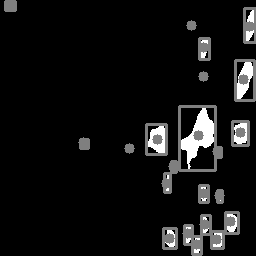

In [ ]:
# finding pixel count of cell bodies

#if you need to re run this cell re reun upper cell first or else results will vary

cellBod=binary_rp
# find connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cellBod, connectivity=8)
totalArea=0
# Output results
for i in range(1, num_labels):  # Skip the background label 0
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]
    print(f"Cell Body {i}: Position (Centroid) = ({cx:.2f}, {cy:.2f}), Size (Area) = {area}")
    totalArea+=area
    # Draw rectangles and centroids on the image for visualization
    cv2.rectangle(cellBod, (x, y), (x + w, y + h), (127), 2)
    cv2.circle(cellBod, (int(cx), int(cy)), 5, (127), -1)

print(f"Total cell count is {num_labels} and total cell area is {totalArea} pixel ")

# Save the result image with drawn areas
cv2.imwrite('cells_detected.png', cellBod)
cv2_imshow(cellBod)


# Step 4

---

By using pre preocessed image prediction and  regular predicetion branch can be isolated to process